In [176]:
import sys
import timeit
import numpy as np
import cv2
from pymoo.core.repair import Repair
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.factory import get_algorithm, get_crossover, get_mutation, get_sampling
from pymoo.problems.single.traveling_salesman import create_random_tsp_problem
from pymoo.util.termination.default import MultiObjectiveDefaultTermination
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.problem import Problem
from scipy.spatial import distance

### Generation des coordonnees des points de passages

In [171]:
cities = np.random.uniform(10,100,(30,2))
np.savetxt('/home/immahighnigga/Desktop/MEMOIRE/figure/cities.csv', cities, delimiter=',')
print(cities)

[[90.89326614 96.1596112 ]
 [48.40728769 54.91336695]
 [29.18873731 10.4110471 ]
 [31.85867896 56.8244186 ]
 [36.2610787  85.91126618]
 [92.34215324 30.26875388]
 [23.58672695 82.18080526]
 [15.87393826 31.81305188]
 [90.79655479 87.44711529]
 [38.92664686 24.50026413]
 [95.81757345 53.54358385]
 [73.6702139  75.65779328]
 [67.45892071 50.2392541 ]
 [46.33443943 33.88999863]
 [53.97204928 54.236491  ]
 [50.963096   39.01536525]
 [65.03679466 88.90952616]
 [13.23413247 14.54668219]
 [35.18116908 87.24051909]
 [85.29965039 74.17937828]
 [81.54543433 25.97174019]
 [54.50470188 65.94178915]
 [71.31296858 41.73961401]
 [14.08763599 23.42531792]
 [27.89653344 87.31863935]
 [34.69892426 47.79038179]
 [68.59121684 93.74582391]
 [14.36041949 15.88439934]
 [71.00899658 64.51224585]
 [87.94743628 79.56836246]]


### Fonction calculant la distance entre deux points

In [172]:
def mdistance(x,y):
        return distance.euclidean(x,y)

### Implementation du probleme

In [271]:
class MoTravelingSalesman(ElementwiseProblem):

    def __init__(self, cities, **kwargs):
        n_cities, _ = cities.shape

        self.cities = cities
        self.D = cdist(cities, cities)

        super(MoTravelingSalesman, self).__init__(
            n_var=n_cities,
            n_obj=1,
            xl=0,
            xu=n_cities,
            type_var=int,
            **kwargs
        )

    def _evaluate(self, x, out, *args, **kwargs):
        
        L = x
        C = x
        
        f1 = self.get_route_length(L)
        f2 = self.get_route_cost1(C)
        
        out['F'] = np.column_stack([f1, f2])

    def get_route_cost1(self, x):
        n_cities = len(x)
        dist = 0
        for k in range(n_cities - 1):
            dist += mdistance(x[k], x[k + 1])
        last, first = x[-1], x[0]
        dist += mdistance(last, first)  # back to the initial city
        return dist

    def get_route_cost(self, x):
        n_cities = len(x)
        dist = 0
        for k in range(n_cities - 1):
            i, j = x[k], x[k + 1]
            dist += self.D[i, j]
        last, first = x[-1], x[0]
        dist += self.D[last, first] # back to the initial city
        return dist
    
    def get_route_length1(self, x):
        n_cities = len(x)
        dist = 0
        for k in range(n_cities - 1):
            dist += mdistance(x[k], x[k + 1])
        last, first = x[-1], x[0]
        dist += mdistance(last, first)  # back to the initial city
        return dist

    def get_route_length(self, x):
        n_cities = len(x)
        dist = 0
        for k in range(n_cities - 1):
            i, j = x[k], x[k + 1]
            dist += self.D[i, j]
        last, first = x[-1], x[0]
        dist += self.D[last, first] # back to the initial city
        return dist


def visualize(problem, x,fig=None, ax=None, show=True, label=True):
    with plt.style.context('ggplot'):

        if fig is None or ax is None:
            fig, ax = plt.subplots()

        # plot cities using scatter plot
        ax.scatter(problem.cities[:, 0], problem.cities[:, 1], s=250)
        if label:
            # annotate cities
            for i, c in enumerate(problem.cities):
                ax.annotate(str(i), xy=c, fontsize=10, ha="center", va="center", color="white")

        # plot the line on the path
        for i in range(len(x)):
            current = x[i]
            next_ = x[(i + 1) % len(x)]
            ax.plot(problem.cities[[current, next_], 0], problem.cities[[current, next_], 1], 'r--')
            
        #fig.suptitle("Route length: %.4f" % problem.get_route_cost1(x))
        fig.suptitle("Graphe")
        fig.savefig('/home/immahighnigga/Desktop/MEMOIRE/figure/graphtsp.png')
        
        if show:
            fig.show()
            

def visualize_on_map(problem, x,fig=None, ax=None, show=True, label=True):
    with plt.style.context('ggplot'):

        if fig is None or ax is None:
            fig, ax = plt.subplots()
        
        # plot cities using scatter plot
        ax.scatter(problem.cities[:, 0], problem.cities[:, 1], s=250)
        if label:
            # annotate cities
            for i, c in enumerate(problem.cities):
                ax.annotate(str(i), xy=c, fontsize=10, ha="center", va="center", color="white")

        # plot the line on the path
        for i in range(len(x)):
            current = x[i]
            next_ = x[(i + 1) % len(x)]
            ax.plot(problem.cities[[current, next_], 0], problem.cities[[current, next_], 1], 'r--')
           
        #fig.suptitle("Route length: %.4f" % problem.get_route_cost1(x))
        fig.suptitle("Graphe/Carte")
        
        
        img = plt.imread("/home/immahighnigga/Desktop/MEMOIRE/figure/map.png")
        ax.imshow(img,extent = [0,120,0,120])
        fig.savefig('/home/immahighnigga/Desktop/MEMOIRE/figure/graphtsponmap.png')
        if show:
            fig.show()

### Implementation de l'algorithme

In [177]:
problem = MoTravelingSalesman(cities)

algorithm = NSGA2(
    pop_size=30,
    sampling=get_sampling("perm_random"),
    crossover=get_crossover("perm_erx"),
    mutation=get_mutation("perm_inv"),
    #repair=StartFromZeroRepair(),
    eliminate_duplicates=True
)
# if the algorithm did not improve the last 200 generations then it will terminate (and disable the max generations)
termination = MultiObjectiveDefaultTermination(n_last=10000, n_max_gen=np.inf)

res = minimize(
    problem,
    algorithm,
    #('n_gen', 5000),
    termination,
    #seed=1,
    verbose=False 
)

### Resultat

In [190]:
F = res.F

### Recherche d'un unique point sur le front de pareto

In [191]:
def unique_solution_index(l):
    min = sys.maxsize
    index = 0;
    for j in range(len(l)):
        dif = l[j][0] - l[j][1]
        if min < dif:
            min = dif
            index = j
    return index

In [192]:
minIndex = unique_solution_index(F)

In [193]:
print('La fonction avec le rapport distance-temps minimale : ',F[minIndex])

La fonction avec le rapport distance-temps minimale :  [408.45301907 314.        ]


### Visualisation

/tmp/ipykernel_10875/2754619446.py:91: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


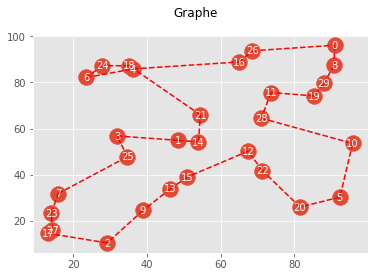

In [272]:
visualize(problem, res.X[minIndex])

/tmp/ipykernel_10875/2754619446.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


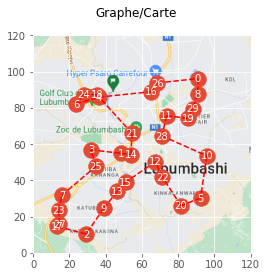

In [273]:
visualize_on_map(problem, res.X[minIndex])

F [[ 408.45301907  314.        ]
 [1140.42911599   58.        ]
 [1065.94622682   60.        ]
 [ 605.36368642  132.        ]
 [1013.08966837   64.        ]
 [ 421.14783556  296.        ]
 [ 578.58508684  140.        ]
 [ 556.10204574  154.        ]
 [ 451.10751289  250.        ]
 [ 764.96524653  100.        ]
 [ 467.00950656  236.        ]
 [ 789.06845468   92.        ]
 [ 723.11599086  106.        ]
 [ 657.30609499  122.        ]
 [ 489.45881317  196.        ]
 [ 498.19891718  184.        ]
 [ 523.0227722   174.        ]
 [ 916.33633748   74.        ]
 [ 697.39275433  112.        ]
 [ 537.1867639   164.        ]
 [ 474.55761465  210.        ]
 [ 968.91745009   68.        ]
 [ 427.84286507  280.        ]
 [ 474.46472591  222.        ]
 [ 444.41248339  266.        ]
 [ 879.38716701   80.        ]
 [ 945.15547747   70.        ]
 [ 862.57351777   82.        ]
 [ 665.30167793  118.        ]
 [ 826.89963047   86.        ]]


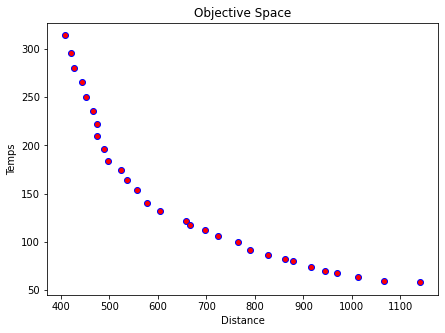

In [220]:
print('F', F)
#print('X',res.X)
np.savetxt('/home/immahighnigga/Desktop/MEMOIRE/figure/fonctions.csv', F, delimiter=',')
plt.figure(figsize=(7, 5))
plt.scatter(F[:,0],F[:,1], facecolors='red', edgecolors='blue')
plt.title("Objective Space")
plt.xlabel("Distance")
plt.ylabel("Temps")
plt.savefig('/home/immahighnigga/Desktop/MEMOIRE/figure/pareto.png')
plt.show()